In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML
import numpy as np

In [2]:
#set constants
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS = 3
EPOCHS = 20

Import data into tensorflow dataset object https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory


In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "./images",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 4500 files belonging to 3 classes.


In [4]:
class_name = dataset.class_names

In [5]:
class_name

['Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_healthy']

In [34]:
len(dataset)

141

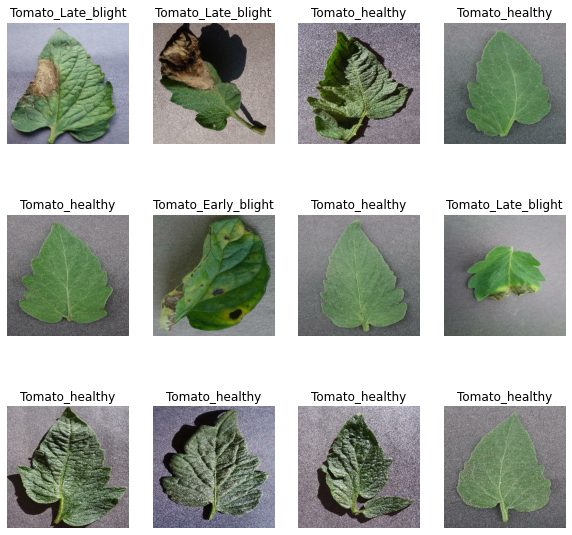

In [6]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
  for i in range(12):
    ax = plt.subplot(3,4, i+1)
    plt.imshow(image_batch[i].numpy().astype('uint8'))
    plt.title(class_name[label_batch[i]])
    plt.axis('off')
  #print(image_batch.shape, label_batch.numpy())

In [35]:
#80% => training
#20%, 10% => validation, 10% => test
def get_data_partition(data, train_split=0.8, validation_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
  data_size = len(data)
  train_size = int(data_size * train_split)
  validation_size = int(data_size * validation_split)
  
  if shuffle:
    data.shuffle(shuffle_size, seed=12)

  train_set = data.take(train_size)
  validation_set = data.skip(train_size).take(validation_size)
  test_set = data.skip(train_size).skip(validation_size)

  return train_set, validation_set, test_set

In [36]:
train_set, validation_set, test_set = get_data_partition(dataset)

In [37]:
len(train_set) 

112

In [38]:
len(validation_set) 

14

In [39]:
len(test_set)

15

In [40]:
train_set = train_set.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
validation_set = validation_set.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_set = test_set.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [41]:
#pre-processing
resize_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1.0/255)
])

data_augmentation = resize_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
  layers.experimental.preprocessing.RandomRotation(0.2)
])

In [42]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
  layers.Conv2D(32, (3,3),  activation='relu', input_shape=input_shape[1:], kernel_regularizer='l2'),
  layers.MaxPooling2D(pool_size=(2, 2)),  

  layers.Conv2D(64, (3,3), activation='relu'),
  layers.MaxPooling2D(pool_size=(2, 2)),

  layers.Conv2D(64, (3,3), activation='relu'),
  layers.MaxPooling2D(pool_size=(2, 2)),
    
  layers.Conv2D(64, (3,3), activation='relu'),
  layers.MaxPooling2D(pool_size=(2, 2)),
    
  layers.Conv2D(64, (3,3), activation='relu'),
  layers.MaxPooling2D(pool_size=(2, 2)),

  layers.Flatten(),

  layers.Dense(64, activation='relu'),
  layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [43]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [44]:
history = model.fit(
    train_set,
    batch_size=BATCH_SIZE,
    validation_data=validation_set,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/30
112/112 [==============================] - 222s 2s/step - loss: 1.0965 - accuracy: 0.7079 - val_loss: 0.4592 - val_accuracy: 0.8304
Epoch 2/30
112/112 [==============================] - 216s 2s/step - loss: 0.3935 - accuracy: 0.8527 - val_loss: 0.3268 - val_accuracy: 0.8683
Epoch 3/30
112/112 [==============================] - 213s 2s/step - loss: 0.3160 - accuracy: 0.8903 - val_loss: 0.3283 - val_accuracy: 0.8728
Epoch 4/30
112/112 [==============================] - 221s 2s/step - loss: 0.2850 - accuracy: 0.9018 - val_loss: 0.2923 - val_accuracy: 0.9040
Epoch 5/30
112/112 [==============================] - 235s 2s/step - loss: 0.2756 - accuracy: 0.9166 - val_loss: 0.2682 - val_accuracy: 0.9018
Epoch 6/30
112/112 [==============================] - 239s 2s/step - loss: 0.2596 - accuracy: 0.9174 - val_loss: 0.2005 - val_accuracy: 0.9330
Epoch 7/30
112/112 [==============================] - 213s 2s/step - loss: 0.1644 - accuracy: 0.9512 - val_loss: 0.1636 - val_accuracy: 0.9420

In [45]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 125, 125, 64)      18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 60, 60, 64)        36928     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 28, 28, 64)       

In [46]:
scores = model.evaluate(test_set)

15/15 [==============================] - 11s 515ms/step - loss: 0.1511 - accuracy: 0.9658


In [47]:
scores

[0.1511339247226715, 0.9658119678497314]

In [48]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 112}

In [49]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

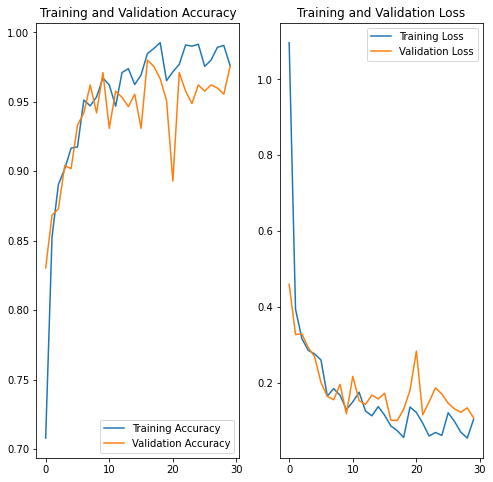

In [50]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Tomato_healthy
predicted label: Tomato_healthy


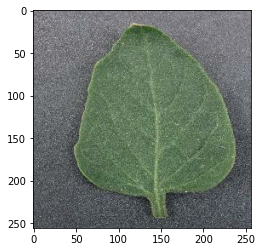

In [51]:
for images_batch, labels_batch in test_set.take(1):
  first_image = images_batch[0].numpy().astype('uint8')
  first_label = labels_batch[0].numpy()
    
  print("first image to predict")
  plt.imshow(first_image)
  print("actual label:",class_name[first_label])
    
  batch_prediction = model.predict(images_batch)
  print("predicted label:",class_name[np.argmax(batch_prediction[0])])

In [52]:
def predict(model, img):
  img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
  img_array = tf.expand_dims(img_array, 0) # Create a batch

  predictions = model.predict(img_array)

  predicted_class = class_name[np.argmax(predictions[0])]
  confidence = round(100 * (np.max(predictions[0])), 2)
  return predicted_class, confidence

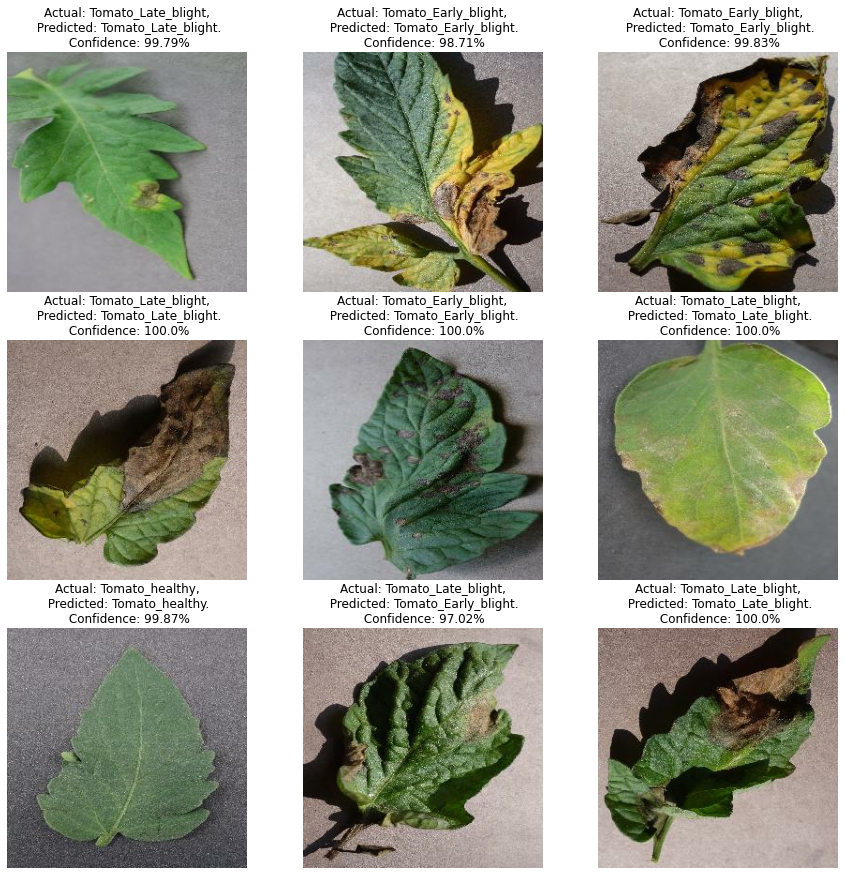

In [53]:
plt.figure(figsize=(15, 15))

for images, labels in test_set.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_name[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [56]:
model_version='1'
model.save(f"./models/potato/{model_version}")

INFO:tensorflow:Assets written to: ./models/potato/1\assets
